## Quantum Classifier – Final Pipeline

This notebook contains the **final, working implementation** of the quantum classifier used in this project.
It is intentionally kept as a **single executable cell** to ensure reproducibility and avoid accidental
changes to results.

### What this cell does (high level)

1. **Loads engineered features** extracted from PLAsTiCC light curves  
   The dataset contains precomputed astronomical features for supernovae (Type Ia vs Type II).

2. **Automatically selects the top 3 features**  
   - Uses point-biserial correlation between each feature and the class label  
   - Selects the 3 most correlated features  
   - This matches the 3-qubit constraint (1 feature per qubit)

3. **Applies outlier-robust preprocessing**  
   - Clips extreme values (1st–99th percentile)  
   - Applies log transforms when features have very large dynamic range  
   - Prevents quantum angle encoding from collapsing due to outliers

4. **Scales features into quantum rotation angles**  
   - Uses MinMax scaling to map values into the range `[0, π]`  
   - This produces valid and well-distributed rotation angles for the quantum circuit

5. **Builds a 3-qubit variational quantum circuit**  
   - Feature map: ZZFeatureMap with entanglement  
   - Ansatz: TwoLocal circuit with trainable parameters  
   - Combined into a single parameterized quantum circuit

6. **Trains a quantum classifier (EstimatorQNN)**  
   - Uses COBYLA (gradient-free optimizer)  
   - Runs for a fixed number of iterations  
   - Training performed on a noiseless statevector simulator

7. **Evaluates performance**  
   - Accuracy, AUC, balanced accuracy  
   - Confusion matrix and classification report  
   - ROC curve visualization  
   - Results are saved to disk for comparison with classical baselines


> **Note:** The goal of this notebook is not to tune hyperparameters,
> but to **understand when quantum ML is appropriate vs when classical ML is more effective**.

Quantum ML — PLAsTiCC (3-qubit EstimatorQNN)
FEATURES_PATH: ../data/plasticc/transient_features.csv
RESULTS_DIR: ../results

Loaded samples: 1072
Label distribution:
 label
SNII    549
SNIa    523
Name: count, dtype: int64

X_full shape: (1072, 16)

Top 10 by |correlation|:
           feature  abs_corr  signed_corr      p_value
         time_span  0.280059    -0.280059 9.061588e-21
      decline_time  0.268915    -0.268915 3.248802e-19
           mag_max  0.150529     0.150529 7.382729e-07
           mag_std  0.142485     0.142485 2.818433e-06
          mag_mean  0.133558     0.133558 1.146827e-05
         mag_range  0.104832     0.104832 5.864396e-04
         rise_time  0.096462    -0.096462 1.567008e-03
mean_decline_slope  0.063565     0.063565 3.744478e-02
         flux_mean  0.041182    -0.041182 1.778611e-01
           mag_min  0.033363     0.033363 2.750981e-01

Selected features (3 qubits): ['time_span', 'decline_time', 'mag_max']

Class separability (rough σ units):
  time_span

/var/folders/4j/986s_f794zq87n31mh_7ls200000gn/T/ipykernel_20221/3032009663.py:221: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()  # note: deprecated warning is OK for now
/var/folders/4j/986s_f794zq87n31mh_7ls200000gn/T/ipykernel_20221/3032009663.py:223: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


✓ Training time: 10.7 min

RESULTS
Accuracy:          0.502
AUC:               0.576
Balanced accuracy: 0.511
Sensitivity SNIa:  0.876
Specificity SNII:  0.145

Confusion matrix [SNII, SNIa]:
[[16 94]
 [13 92]]

Classification report:
              precision    recall  f1-score   support

        SNII       0.55      0.15      0.23       110
        SNIa       0.49      0.88      0.63       105

    accuracy                           0.50       215
   macro avg       0.52      0.51      0.43       215
weighted avg       0.52      0.50      0.43       215



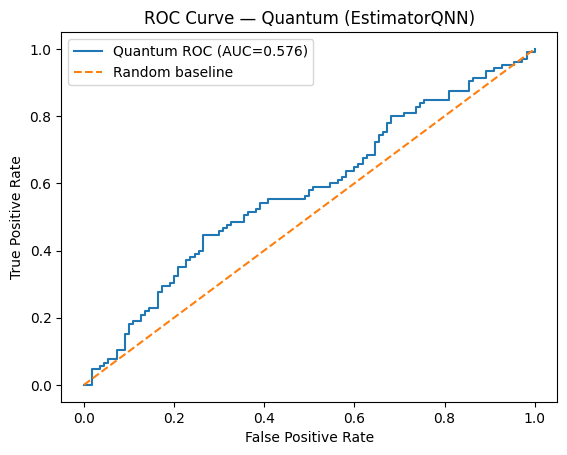


Saved results to: ../results/plasticc_quantum_results_final.json


In [1]:
# ============================================================
# 03_quantum_classifier.ipynb 
# FINAL VERSION WITH AUTO FEATURE SELECTION
# ============================================================

import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

from scipy.stats import pointbiserialr

# Qiskit / QML
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier


# -----------------------------
# 0) Config
# -----------------------------
DATA_DIR = os.path.join("..", "data", "plasticc")
FEATURES_PATH = os.path.join(DATA_DIR, "transient_features.csv")

RESULTS_DIR = os.path.join("..", "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.2
OUT_JSON = os.path.join(RESULTS_DIR, "plasticc_quantum_results_final.json")


print("=" * 70)
print("Quantum ML — PLAsTiCC (3-qubit EstimatorQNN)")
print("=" * 70)
print("FEATURES_PATH:", FEATURES_PATH)
print("RESULTS_DIR:", RESULTS_DIR)


# -----------------------------
# 1) Load data
# -----------------------------
features_df = pd.read_csv(FEATURES_PATH)
print("\nLoaded samples:", len(features_df))
print("Label distribution:\n", features_df["label"].value_counts())

label_map = {"SNII": 0, "SNIa": 1}
y = features_df["label"].map(label_map).values
if np.any(pd.isnull(y)):
    bad = features_df.loc[pd.isnull(y), "label"].unique()
    raise ValueError(f"Unknown labels found: {bad}")


# -----------------------------
# 2) Define engineered feature columns (expected)
# -----------------------------
feature_cols = [
    "mag_min", "mag_max", "mag_mean", "mag_std", "mag_range",
    "flux_max", "flux_mean", "flux_std",
    "time_span", "rise_time", "decline_time", "rise_decline_ratio",
    "mean_rise_slope", "mean_decline_slope", "max_slope",
    "n_points"
]

missing = [c for c in feature_cols if c not in features_df.columns]
if missing:
    raise ValueError(f"Missing expected features in CSV: {missing}")

X_full = features_df[feature_cols].values
print("\nX_full shape:", X_full.shape)


# -----------------------------
# 3) Auto-select top 3 features (point-biserial correlation)
# -----------------------------
correlations = []
for i, feat in enumerate(feature_cols):
    corr, pval = pointbiserialr(y, X_full[:, i])
    correlations.append({
        "feature": feat,
        "abs_corr": float(abs(corr)),
        "signed_corr": float(corr),
        "p_value": float(pval),
    })

corr_df = pd.DataFrame(correlations).sort_values("abs_corr", ascending=False)
selected_features = corr_df.head(3)["feature"].tolist()

print("\nTop 10 by |correlation|:")
print(corr_df.head(10).to_string(index=False))
print("\nSelected features (3 qubits):", selected_features)


def separation_sigma(feature_values, y_binary):
    a = feature_values[y_binary == 1]  # SNIa
    b = feature_values[y_binary == 0]  # SNII
    sep = abs(a.mean() - b.mean())
    denom = b.std() if b.std() > 0 else 1e-12
    return float(sep / denom), float(a.mean()), float(a.std()), float(b.mean()), float(b.std())


print("\nClass separability (rough σ units):")
for feat in selected_features:
    vals = features_df[feat].values
    sep_sigma, a_mu, a_sd, b_mu, b_sd = separation_sigma(vals, y)
    print(f"  {feat:<18} {sep_sigma:>5.2f}σ   | SNIa μ={a_mu:.3f} σ={a_sd:.3f} | SNII μ={b_mu:.3f} σ={b_sd:.3f}")


# -----------------------------
# 4) Preprocessing: clip outliers + optional log transform
# -----------------------------
X_selected = features_df[selected_features].values

# Clean NaN/Inf defensively
if np.any(np.isnan(X_selected)) or np.any(np.isinf(X_selected)):
    print("\n⚠️ Found NaN/Inf in features — cleaning with nan_to_num.")
    X_selected = np.nan_to_num(X_selected, nan=0.0, posinf=1e10, neginf=-1e10)

# Clip outliers (1st/99th)
X_proc = X_selected.copy()
clip_bounds = []
for i in range(X_proc.shape[1]):
    p1, p99 = np.percentile(X_proc[:, i], [1, 99])
    X_proc[:, i] = np.clip(X_proc[:, i], p1, p99)
    clip_bounds.append((float(p1), float(p99)))

print("\nClip bounds (p1, p99) per feature:")
for feat, (p1, p99) in zip(selected_features, clip_bounds):
    print(f"  {feat}: [{p1:.4f}, {p99:.4f}]")

# Conditional log transform
log_transformed = []
for i in range(X_proc.shape[1]):
    fmin, fmax = X_proc[:, i].min(), X_proc[:, i].max()
    dynamic_range = (fmax - fmin) / (abs(fmin) + 1e-10)
    if dynamic_range > 100:
        X_proc[:, i] = np.log1p(X_proc[:, i] - X_proc[:, i].min() + 1)
        log_transformed.append(selected_features[i])

print("Log-transformed features:", log_transformed if log_transformed else "None")


# -----------------------------
# 5) Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("\nTrain:", X_train.shape, "Test:", X_test.shape)
print("Train label counts:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Test  label counts:", dict(zip(*np.unique(y_test, return_counts=True))))


# -----------------------------
# 6) Scale to quantum angles [0, π]
# -----------------------------
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_train_angles = scaler.fit_transform(X_train)
X_test_angles = scaler.transform(X_test)

print("\nAngle stats (train):")
print("  min:   ", X_train_angles.min(axis=0))
print("  max:   ", X_train_angles.max(axis=0))
print("  mean:  ", X_train_angles.mean(axis=0))
print("  median:", np.median(X_train_angles, axis=0))


# -----------------------------
# 7) Build quantum circuit (feature map + ansatz)
# -----------------------------
num_qubits = X_train_angles.shape[1]

feature_map = ZZFeatureMap(
    feature_dimension=num_qubits,
    reps=2,
    entanglement="full"
)

ansatz = TwoLocal(
    num_qubits=num_qubits,
    reps=3,
    rotation_blocks=["ry", "rz"],
    entanglement_blocks="cz",
    entanglement="full"
)

from qiskit import QuantumCircuit
circuit = QuantumCircuit(num_qubits)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)

print("\nCircuit:")
print("  qubits:          ", num_qubits)
print("  depth:           ", circuit.depth())
print("  total params:    ", circuit.num_parameters)
print("  input params:    ", len(list(feature_map.parameters)))
print("  trainable params:", len(list(ansatz.parameters)))


# -----------------------------
# 8) Create QNN + classifier
# -----------------------------
estimator = Estimator()  # note: deprecated warning is OK for now

qnn = EstimatorQNN(
    estimator=estimator,
    circuit=circuit,
    input_params=list(feature_map.parameters),
    weight_params=list(ansatz.parameters),
)

optimizer = COBYLA(maxiter=300)

q_clf = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=optimizer,
    one_hot=False,
)


# -----------------------------
# 9) Train
# -----------------------------
print("\nTraining… (COBYLA maxiter=300)")
start = time.time()
q_clf.fit(X_train_angles, y_train)
training_time = time.time() - start
print(f"✓ Training time: {training_time/60:.1f} min")


# -----------------------------
# 10) Evaluate + ROC curve
# -----------------------------
# Predict returns {-1,+1} sometimes; map to {0,1}
y_pred_raw = q_clf.predict(X_test_angles)
y_pred = np.where(y_pred_raw <= 0, 0, 1)

# predict_proba returns (n,1) in this setup; treat as score
scores = q_clf.predict_proba(X_test_angles).ravel()

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, scores)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) else 0.0  # SNIa recall
specificity = tn / (tn + fp) if (tn + fp) else 0.0  # SNII recall
balanced_acc = 0.5 * (sensitivity + specificity)

print("\n" + "=" * 70)
print("RESULTS")
print("=" * 70)
print(f"Accuracy:          {acc:.3f}")
print(f"AUC:               {auc:.3f}")
print(f"Balanced accuracy: {balanced_acc:.3f}")
print(f"Sensitivity SNIa:  {sensitivity:.3f}")
print(f"Specificity SNII:  {specificity:.3f}")

print("\nConfusion matrix [SNII, SNIa]:")
print(cm)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["SNII", "SNIa"], zero_division=0))

# ROC curve plot
fpr, tpr, _ = roc_curve(y_test, scores)
plt.figure()
plt.plot(fpr, tpr, label=f"Quantum ROC (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Quantum (EstimatorQNN)")
plt.legend()
plt.show()


# -----------------------------
# 11) Save results JSON
# -----------------------------
results = {
    "dataset_size": int(len(features_df)),
    "train_size": int(len(X_train)),
    "test_size": int(len(X_test)),
    "model": "EstimatorQNN",
    "features_selected_auto": selected_features,
    "feature_selection_method": "top3_by_abs_pointbiserial_correlation",
    "preprocessing": {
        "outlier_clipping": "1st/99th percentile",
        "clip_bounds": {feat: {"p1": p1, "p99": p99} for feat, (p1, p99) in zip(selected_features, clip_bounds)},
        "log_transformed_features": log_transformed,
        "angle_scaling": "[0, pi] via MinMaxScaler",
    },
    "circuit": {
        "qubits": int(num_qubits),
        "feature_map": {"type": "ZZFeatureMap", "reps": 2, "entanglement": "full"},
        "ansatz": {"type": "TwoLocal", "reps": 3, "rotations": ["ry", "rz"], "entanglement_gate": "cz", "entanglement": "full"},
        "depth": int(circuit.depth()),
        "total_params": int(circuit.num_parameters),
        "trainable_params": int(len(list(ansatz.parameters))),
    },
    "optimizer": {"type": "COBYLA", "maxiter": 300},
    "training_time_seconds": float(training_time),
    "metrics": {
        "accuracy": float(acc),
        "auc": float(auc),
        "balanced_accuracy": float(balanced_acc),
        "sensitivity_snia": float(sensitivity),
        "specificity_snii": float(specificity),
        "confusion_matrix": cm.tolist(),
    },
}

with open(OUT_JSON, "w") as f:
    json.dump(results, f, indent=2)

print("\nSaved results to:", OUT_JSON)